In [3]:
import random
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dot, Lambda, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2

**Loading the data in pairs. The shape of x_train_pairs would be (BatchCount, 2, width, height), 2 meaning we have 2 images to make the pair.
The y_train_label will have a 1D array of labels- 0 for dissimilar images and 1 for similar images.**

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

In [12]:
digit_indices = [np.where(y_train == i) for i in range(10)]
digit_indices

[(array([    1,     2,     4, ..., 59974, 59985, 59998]),),
 (array([   16,    21,    38, ..., 59989, 59991, 59996]),),
 (array([    5,     7,    27, ..., 59977, 59981, 59993]),),
 (array([    3,    20,    25, ..., 59971, 59980, 59997]),),
 (array([   19,    22,    24, ..., 59984, 59986, 59990]),),
 (array([    8,     9,    12, ..., 59983, 59995, 59999]),),
 (array([   18,    32,    33, ..., 59973, 59987, 59988]),),
 (array([    6,    14,    41, ..., 59951, 59979, 59992]),),
 (array([   23,    35,    57, ..., 59962, 59967, 59994]),),
 (array([    0,    11,    15, ..., 59932, 59970, 59978]),)]

In [13]:

# make pairs
def make_pairs(x, y):
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [1]
    
        # add a not matching example
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels)

x_train_pairs, y_train_label = make_pairs(x_train, y_train)
x_test_pairs, y_test_label = make_pairs(x_test, y_test)

In [14]:
x_train_pairs = x_train_pairs[...,np.newaxis] # convolution needs to have (28,28,1)
x_test_pairs = x_test_pairs[...,np.newaxis]
print(x_train_pairs.shape)
print(x_test_pairs.shape)

(120000, 2, 28, 28, 1)
(20000, 2, 28, 28, 1)


**Visualising the data we prepared:**

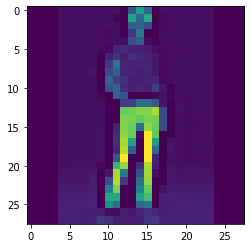

In [20]:
plt.imshow(x_train_pairs[1701,0]) #the result would be (28,28,1) image of the 1701th row count

0


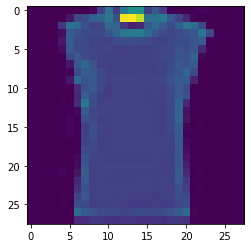

In [19]:
plt.imshow(x_train_pairs[1701,1]) # A trouser above and a shirt/tshirt below are dissimilar thus label=0
print(y_train_label[1701])

### Defining Siamese Model

In [21]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [22]:
# Euclidean distance function
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


In [28]:
# https://github.com/lukas/ml-class/blob/master/videos/one-shot/One%20Shot.ipynb
# Basic model from here.

# input = Input((128,128))
# x = Flatten()(input)
# x = Dense(128, activation='relu')(x)
# dense = Model(input, x)

# input1 = Input((128,128))
# input2 = Input((128,128))

# dense1 = dense(input1)
# dense2 = dense(input2)

# merge_layer = Lambda(euclidean_distance)([dense1,dense2])
# dense_layer = Dense(1, activation="sigmoid")(merge_layer)

# model = Model(inputs=[input1, input2], outputs=dense_layer)

In [27]:
initializer = tf.keras.initializers.GlorotNormal()

inputs = layers.Input(shape=(28,28,1))
x = layers.Conv2D(16, (3,3), activation=tf.keras.layers.LeakyReLU(alpha=0.3), padding='same', 
                  kernel_initializer=initializer)(inputs)
x = layers.Conv2D(32, (3,3), activation=tf.keras.layers.LeakyReLU(alpha=0.3), padding='same', 
                  kernel_initializer=initializer)(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(64, (3,3), activation=tf.keras.layers.LeakyReLU(alpha=0.3), padding='same', 
                  kernel_initializer=initializer)(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Dropout(0.4)(x)
x = layers.Conv2D(128, (3,3), activation=tf.keras.layers.LeakyReLU(alpha=0.3), padding='same', 
                  kernel_initializer=initializer)(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Dropout(0.4)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.3), kernel_initializer=initializer)(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(28)(x)

embedding = Model(inputs, output, name="Embedding") #gives 28 embedding output model.

imgA = layers.Input(shape=(28,28,1))
imgB = layers.Input(shape=(28,28,1))
featsA = embedding(imgA)
featsB = embedding(imgB)

distance = layers.Lambda(euclidean_distance)([featsA, featsB])
# print("Output of Lambda layer is: ", distance)
final_distance = layers.Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=final_distance)


In [28]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
Embedding (Functional)          (None, 28)           172764      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           Embedding[0][0]            

In [25]:
# Early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

In [29]:
# wandb.init(project="siamese")
model.fit([x_train_pairs[:,0], x_train_pairs[:,1]], y_train_label[:], validation_split=0.1,
          batch_size=16, epochs=100, callbacks=[callback])

Epoch 1/100
6750/6750 [==============================] - 386s 57ms/step - loss: 0.6926 - accuracy: 0.4980 - val_loss: 0.4635 - val_accuracy: 0.8290
Epoch 2/100
6750/6750 [==============================] - 379s 56ms/step - loss: 0.4160 - accuracy: 0.8180 - val_loss: 0.2984 - val_accuracy: 0.8748
Epoch 3/100
6750/6750 [==============================] - 384s 57ms/step - loss: 0.3248 - accuracy: 0.8654 - val_loss: 0.2480 - val_accuracy: 0.9016
Epoch 4/100
6750/6750 [==============================] - 382s 57ms/step - loss: 0.2763 - accuracy: 0.8906 - val_loss: 0.2415 - val_accuracy: 0.9018
Epoch 5/100
6750/6750 [==============================] - 385s 57ms/step - loss: 0.2501 - accuracy: 0.8999 - val_loss: 0.2152 - val_accuracy: 0.9158
Epoch 6/100
6750/6750 [==============================] - 384s 57ms/step - loss: 0.2388 - accuracy: 0.9053 - val_loss: 0.2023 - val_accuracy: 0.9237
Epoch 7/100
6750/6750 [==============================] - 389s 58ms/step - loss: 0.2275 - accuracy: 0.9093 - val_

In [30]:
model.evaluate([x_test_pairs[:,0], x_test_pairs[:,1]], y_test_label)

625/625 [==============================] - 16s 25ms/step - loss: 0.1586 - accuracy: 0.9424


[0.15864908695220947, 0.9423999786376953]